## Checkpoints
- [ ] ``load -> save -> compare``
- [ ] ``make pkg from scratch``
- [ ] ``layers generator``

In [30]:
import os

conda_env = bool(os.getenv('CONDA_DEFAULT_ENV')) or bool(os.getenv('CONDA_PYTHON_EXE'))  or bool(os.getenv('CONDA_DIR'))
print(conda_env)

True


In [31]:
upgrade_py = True
if upgrade_py:
    if conda_env:
        !conda install -y python-dotenv
    else:
        !python3.10 -m pip install --upgrade pip
        !pip install graph-notebook
        !pip install graphviz
        !pip install pydot
        !pip install networkx
        !pip install pyvis
        !pip install platform
        !pip install hashlib
        !pip install jycm
        !pip install pipreqs
%load_ext line_profiler

Channels:
 - defaults
 - conda-forge
 - pytorch
 - nvidia
 - anaconda
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: | 


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 24.11.3

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


ERROR: Could not find a version that satisfies the requirement platform (from versions: none)
ERROR: No matching distribution found for platform
ERROR: Ignored the following yanked versions: 20081119
ERROR: Could not find a version that satisfies the requirement hashlib (from versions: none)
ERROR: No matching distribution found for hashlib
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [32]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [33]:
import os
import sys
import matplotlib.pyplot as plt
import networkx as nx
import json
import pprint
import numpy as np
import pandas as pd
import time
import platform
import hashlib
from enum import Enum
from pyvis.network import Network
from IPython.display import display, HTML
import copy
import tqdm
from jycm.jycm import YouchamaJsonDiffer
from IPython.display import JSON
from IPython.display import Markdown

from pathlib import Path
os.environ["MGENN_DEBUG"] = "Y"


In [34]:
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(Path(os.getcwd()).parent.absolute())

import mcore as mc

from common import *

In [35]:
pkg = mc.Package()
pkg.loadFile('data/namespacetest_rev0.pkg')
pkg.counts()


[2025-01-08 16:14:57]in[counts.306] inputs:9, outputs:10, neurons:10, links:10, total:39


In [36]:
def showGraph(pkg):
    #net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
    nt = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True, directed =True)

    ZH = "ZERO_HOLE"
    def hasNode(nodes, key)->bool:
        for node in nx_graph.nodes:
            if str(node) == str(key):
                return True
        return False
    nx_graph = nx.DiGraph()

    for n in pkg.neurons:
        nx_graph.add_node(str(n["id"]), size = 10 + int(float(n["currentEnergy"])), title=('neuron %d' % n["id"]), group=1)
    for o in pkg.outputs:
        nx_graph.add_node(str(o["id"]), size = 10, title=('outputs %d' % n["id"]), group=2)
    for i in pkg.inputs:
        nx_graph.add_node(str(i["name"]), size = 5, title=('input %s' % i["name"]), group=3)

    #make direct links
    nx_graph.add_node(str(ZH), size = 1, title=("missed node"), group=1)
    l = pkg.links[1]
    start, stop = pkg.linkEnds(l)
    #print("link ", start, " to " , stop)
    #nx_graph.add_edge(str(start), str(stop))

    for l in pkg.links:
        print(l)
        start, stop = pkg.linkEnds(l)
        link_len = int(l['length'])
        print("link ", start, " to " , str(stop), " sz:", link_len)
        if not start:
            continue
            nx_graph.add_edge(ZH, stop, length = (link_len + 1), weight=(link_len + 1))
        if not hasNode(nx_graph.nodes, str(stop)):
            continue
            nx_graph.add_edge(ZH, stop, value = (link_len + 1), weight=(link_len + 1))
        nx_graph.add_edge(str(start), str(stop), length = (link_len + 1), weight=(link_len + 1) )

    for n in pkg.neurons:
        for rc in n['receivers']:
            if not pkg.isLink(rc):
                nx_graph.add_edge(str(n["id"]), str(rc), length = 1, weight = 1)
    nt.from_nx(nx_graph)
    return nt.show('nx.html')

In [37]:
showGraph(pkg)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
{'attenuationPerTick': '0.020000', 'events': [], 'id': 10, 'length': 2, 'receiverId': 64}
[2025-01-08 16:14:58]in[linkEnds.339] link 10 is hanging down
link  0  to  64  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 11, 'length': 2, 'receiverId': 65}
link  Alias1  to  65  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 12, 'length': 2, 'receiverId': 66}
link  Alias2  to  66  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 13, 'length': 2, 'receiverId': 67}
link  Alias3  to  67  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 14, 'length': 2, 'receiverId': 68}
link  Alias4  to  68  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 15, 'length': 2, 'receiverId': 69}
link  Alias5  to  69  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 16, 'length': 2, 'receiverId': 70}
link  Alias6  to  70  sz: 2
{'attenuationPerTick': '0.020000',

## low-level generators

In [38]:


p = pkg.clone()
n1 = ObjectFactory.makeNeuronData(peak = 10.0, receivers = [], leak = 0.1, currentEnergy = 3.0, id = p.nextId())
p.neurons.append(n1)
p.connect(n1["id"], 64)
p.connect(n1["id"], 65)
p.connect(n1["id"], 69)
g = showGraph(p)
print("new object",n1["id"])
g
pkg = None

[2025-01-08 16:14:58]in[connect.359] linked N[110] to 64
[2025-01-08 16:14:58]in[connect.359] linked N[110] to 65
[2025-01-08 16:14:58]in[connect.359] linked N[110] to 69
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
{'attenuationPerTick': '0.020000', 'events': [], 'id': 10, 'length': 2, 'receiverId': 64}
[2025-01-08 16:14:58]in[linkEnds.339] link 10 is hanging down
link  0  to  64  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 11, 'length': 2, 'receiverId': 65}
link  Alias1  to  65  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 12, 'length': 2, 'receiverId': 66}
link  Alias2  to  66  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 13, 'length': 2, 'receiverId': 67}
link  Alias3  to  67  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 14, 'length': 2, 'receiverId': 68}
link  Alias4  to  68  sz: 2
{'attenuationPerTick': '0.020000', 'events': [], 'id': 15, 'length': 2, 'receiverId': 69}
link  Ali

## high-level generators

In [39]:
pkg = mc.Package.make_empty()
n1 = pkg.new_neuron(leak=1.0, peak=5.0, receivers=[])
i1 = pkg.new_tape_input("i1", [])
o1 = pkg.new_output("o1")

l1 = pkg.new_link_between(apt=0.0, length=1, src=i1, dst=n1)
l2 = pkg.new_link_between(apt=0.0, length=1, src=n1, dst=o1)
print(f"i_{i1} --[{l1}]-> N_{n1} --[{l2}]-> o_{o1}")
showGraph(pkg)

[2025-01-08 16:14:58]in[connect.367] linked I[i1] to 3
[2025-01-08 16:14:58]in[connect.359] linked N[1] to 4
i_i1 --[3]-> N_1 --[4]-> o_2
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
{'attenuationPerTick': 0.0, 'events': [], 'id': 3, 'length': 1, 'receiverId': 1}
link  i1  to  1  sz: 1
{'attenuationPerTick': 0.0, 'events': [], 'id': 4, 'length': 1, 'receiverId': 2}
link  1  to  2  sz: 1


# simple network

In [40]:
F.make_quiet()
pkg = mc.Package.make_empty()
n1 = pkg.new_neuron(leak=1.0, peak=5.0, receivers=[])
i1 = pkg.new_tape_input("i1", [])
o1 = pkg.new_output("o1")

l1 = pkg.new_link_between(apt=0.0, length=1, src=i1, dst=n1)
l2 = pkg.new_link_between(apt=0.0, length=1, src=n1, dst=o1)
ce = mc.Engine()
ce.core = mc.Core()
ce.core.load(pkg)
ce.tick_offset = 0

df_expected = pd.DataFrame([0.0]*7 + [5.0] + [0.0]*4, columns=['o1_exp'])
df_in = pd.DataFrame([3,0] * 6, columns=['i1'])
out = [0] * 9 + [5, 0]
ticks = 12
df_out = pd.DataFrame()
for t in range(ticks):
    df_out = pd.concat([df_out, ce.run_once(df_in)], ignore_index=True)



[2024-12-27 15:36:49]in[__process_autoinputs.153] autoinputs made 0 new events
[2024-12-27 15:36:49]in[dprint.58] TapeInputsRow h[1], d[s1.dim1]
[2024-12-27 15:36:49]in[makeEvents.115] proces point [i1] : ([3], {})
[2024-12-27 15:36:49]in[dprint.58] TapeInputsRow h[1], d[s1.dim1]
[2024-12-27 15:36:49]in[__process_tapes.160] tape container made 1 new events
[2024-12-27 15:36:49]in[__on_e_changed.85] N[1] changed 2.0 --> 1.0 in [onTick.82]
[2024-12-27 15:36:49]in[onRobotsEvent.31] @ Link.3.bfc4c7ec7e14ef53 LINK_APPLY_EVENT : {'tick': 10, 'amp': 3.0, 'from': 'i1'}
[2024-12-27 15:36:49]in[__process_content.166] active content (4 objects) made 1 new events
[2024-12-27 15:36:49]in[__process_events.177] process p.event i1->Link_3 amp:0
[2024-12-27 15:36:49]in[onRobotsEvent.31] @ Link.3.764e00faf6fb076a LINK_IGNORE_SIGNAL : {'tick': 10, 'amp': 0, 'from': 'i1'}
[2024-12-27 15:36:49]in[__process_events.177] process p.event 3->Neuron_1 amp:3.0
[2024-12-27 15:36:49]in[onRobotsEvent.31] @ Neuron.1.

In [41]:
io = pd.concat([df_in, df_out, df_expected], axis=1)
io['error'] = io['o1'].astype(float) - io['o1_exp'].astype(float)
io

,i1,o1,o1_exp,error
0,3,0.0,0.0,0.0
1,0,0.0,0.0,0.0
2,3,0.0,0.0,0.0
3,0,0.0,0.0,0.0
4,3,0.0,0.0,0.0
5,0,0.0,0.0,0.0
6,3,0.0,0.0,0.0
7,0,5.0,5.0,0.0
8,3,0.0,0.0,0.0
9,0,0.0,0.0,0.0


# Worm with breakpoints
## make worm

In [42]:
F.make_quiet()
#F.make_verbose()
pkg = mc.Package.make_empty()
o_end = pkg.new_output("o_end")
w_size = 10
last_o = o_end
last_n = None
ns = []
for i in range(w_size):
    ni = pkg.new_neuron(leak=0.0, peak=5.0, receivers=[])
    pkg.new_link_between(apt=0.0, length=1, src=ni, dst=last_o)
    last_o = pkg.new_output(f"o_end-{i}")
    ns.append(ni)
    if last_n:
        pkg.new_link_between(apt=1.0, length=1, src=ni, dst=last_n)
    last_n = ni
i1 = pkg.new_tape_input("i1", [])
pkg.new_link_between(apt=0.0, length=1, src=i1, dst=last_n)
showGraph(pkg)


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
{'attenuationPerTick': 0.0, 'events': [], 'id': 3, 'length': 1, 'receiverId': 1}
link  2  to  1  sz: 1
{'attenuationPerTick': 0.0, 'events': [], 'id': 6, 'length': 1, 'receiverId': 4}
link  5  to  4  sz: 1
{'attenuationPerTick': 1.0, 'events': [], 'id': 8, 'length': 1, 'receiverId': 2}
link  5  to  2  sz: 1
{'attenuationPerTick': 0.0, 'events': [], 'id': 10, 'length': 1, 'receiverId': 7}
link  9  to  7  sz: 1
{'attenuationPerTick': 1.0, 'events': [], 'id': 12, 'length': 1, 'receiverId': 5}
link  9  to  5  sz: 1
{'attenuationPerTick': 0.0, 'events': [], 'id': 14, 'length': 1, 'receiverId': 11}
link  13  to  11  sz: 1
{'attenuationPerTick': 1.0, 'events': [], 'id': 16, 'length': 1, 'receiverId': 9}
link  13  to  9  sz: 1
{'attenuationPerTick': 0.0, 'events': [], 'id': 18, 'length': 1, 'receiverId': 15}
link  17  to  15  sz: 1
{'attenuationPerTick': 1.0, 'events': [], 'id': 20, 'length': 1, 'receiverId': 13

## run worm

100%|██████████| 200/200 [00:23<00:00,  8.64it/s]


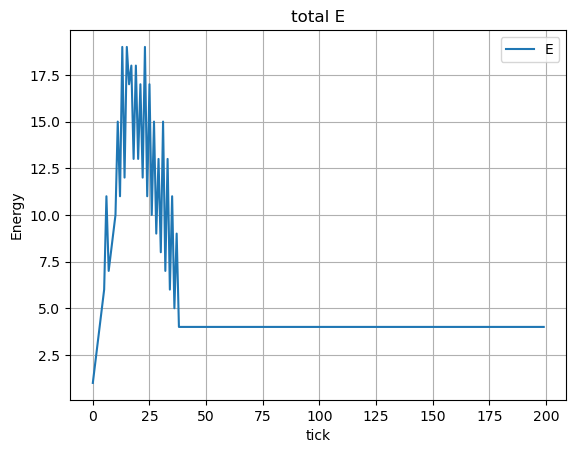

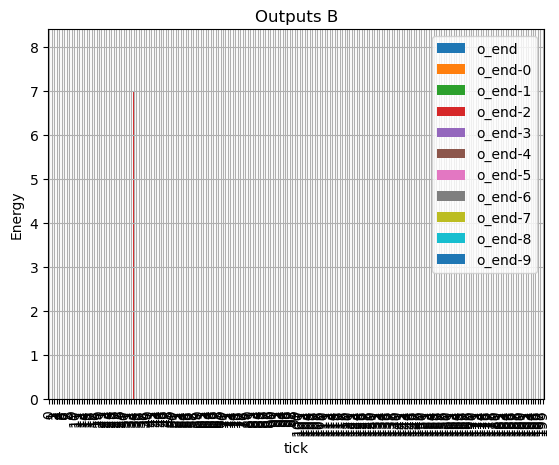

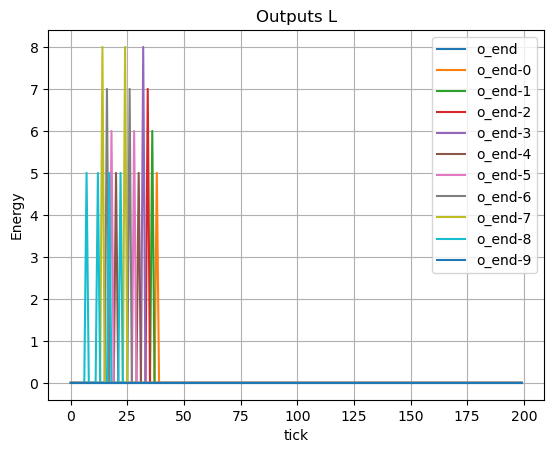

In [43]:

ce = None
dirty_pkg = pkg.clone()
ce = mc.Engine()
ce.core = mc.Core()
ce.core.load(dirty_pkg)
ce.tick_offset = 0
ticks = 200
df_expected = pd.DataFrame([1.0]*(20) + [0.0]*(ticks-20), columns=['o_end'])
df_in = pd.DataFrame([1.0]*(20) + [0.0]*(ticks-20), columns=['i1'])
total_energy = []

df_out = pd.DataFrame()
for t in tqdm.tqdm(range(ticks)):
    df_out = pd.concat([df_out, ce.run_once(df_in)], ignore_index=True)
    dpkg = ce.core.dump()
    energy = dpkg.total_energy()
    total_energy.append(energy)
e_df = pd.DataFrame(total_energy, columns=["E"])
ax = e_df.plot(kind='line', title='total E', grid='on')
plt.xlabel('tick')
plt.ylabel('Energy')
plt.show()



## bars output
ax = df_out.plot(kind='bar', title='Outputs B', grid='on')
plt.xlabel('tick')
plt.ylabel('Energy')
plt.show()

#line output
ax = df_out.plot(kind='line', title='Outputs L', grid='on')
plt.xlabel('tick')
plt.ylabel('Energy')
plt.show()

In [44]:
df_out

,o_end,o_end-0,o_end-1,o_end-2,o_end-3,o_end-4,o_end-5,o_end-6,o_end-7,o_end-8,o_end-9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
